## `struct --- バイナリデータとして解釈させる標準モジュール`
このモジュールは、 Python の値と Python bytes オブジェクトとして表される C の構造体データとの間の変換を実現します。  
このモジュールは特に、ファイルに保存されたり、ネットワーク接続を経由したバイナリデータを扱うときに使われます。  
このモジュールでは、C 構造体のレイアウトおよび Python の値との間で、行いたい変換をコンパクトに表現するために文字列を扱います。

**バイナリデータ**は、コンピュータが直接読解できるデータの形になります。  
  
### なぜ、わざわざバイナリデータ化したり、しかもC言語な構造化をベースにするのか？
**[Pythonプログラムが遅い！高速化したい！そんな時は...](https://qiita.com/sotasato/items/cc36a532ba6487dd3dba)**  
  
結構、データやアプリケーションが大きくなってくると、バイナリデータで扱ったりしたくなってきます。  
※コンピュータが直接読解できるということは、速く処理できる  

ネイティブ(手元の環境)のバイトオーダはビッグエンディアンかリトルエンディアンで、ホスト計算機に依存します。  
例えば、Intel x86 および AMD64 (x86-64) はリトルエンディアンです。  
Motorola 68000 および PowerPC G5 はビッグエンディアンです。  
ARM および Intel Itanium は[エンディアン](https://ja.wikipedia.org/wiki/%E3%82%A8%E3%83%B3%E3%83%87%E3%82%A3%E3%82%A2%E3%83%B3)を切り替えられる機能を備えています (バイエンディアン)。  

エンディアンは `sys.byteorder` を使って調べられます。

In [15]:
import sys

In [16]:
print(sys.byteorder)

little


|記号 |C|Python|
| :---: | :---: | :---: |
|x |パディングバイト|値なし|
|c |char |長さ 1 のバイト列|
|b|signed char|整数|
|B|unsigned char|整数|
|?|Bool|真偽値型(bool)|
|h|short|整数|
|H|unsigned short|整数|
|i|int|整数|
|I|unsigned int|整数|
|l|long|整数|
|L|unsigned long|整数|
|q|long long|整数|
|Q|unsigned long long|整数|
|n|ssize_t|整数|
|N|size_t|整数|
|f|float|浮動小数点数|
|d|double|浮動小数点数|
|s|char[]|bytes|
|p|char[]|bytes|

**バイナリを読んでいるとどうしてもパティング（アライメント合わせのためのゴミ領域）が出てきます。**  
**xフォーマットを使用すると、データを読み飛ばしてくれるので便利です。**  

In [12]:
from struct import *
import struct

In [13]:
data = b'd\x00\xb0\x04'

# NG
kind, _, value = struct.unpack("BBH", data)

# Yes!
kind, value = struct.unpack("BxH", data)

In [14]:
kind, _, value 

(100, 0, 1200)

In [15]:
kind, value

(100, 1200)

**サンプルイメージをバイナリで、読み込んでみる**

In [16]:
png_data = open("sample.png", "rb").read()
struct.unpack_from(">I4sIIBB", png_data, 8)

(13, b'IHDR', 886, 886, 8, 6)

In [19]:
#png_data

In [20]:
from PIL import Image
import numpy as np

In [21]:
im = np.array(Image.open("sample.png"))

In [22]:
import matplotlib.pyplot as plt

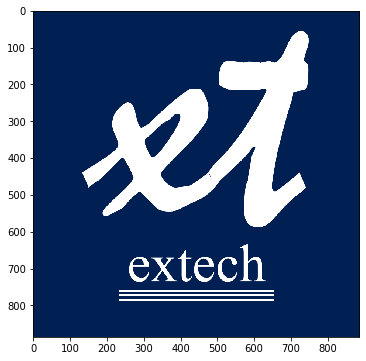

In [23]:
fig = plt.figure(figsize=(8,6))
plt.imshow(im)
plt.show()

In [2]:
pack('hhl', 1, 2, 3)

b'\x01\x00\x02\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00'

In [4]:
unpack('hhl', b'\x01\x00\x02\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00')

(1, 2, 3)

In [5]:
calcsize('hhl')

16

In [6]:
record = b'raymond   \x32\x12\x08\x01\x08'

In [7]:
name, serialnum, school, gradelevel = unpack('<10sHHb', record)

**アンパックした結果のフィールドは、変数に割り当てるか `namedtuple`でラップすることによって名前を付けることができます**

In [8]:
from collections import namedtuple

In [9]:
Student = namedtuple('Student', 'name serialnum school gradelevel')

In [10]:
Student._make(unpack('<10sHHb', record))

Student(name=b'raymond   ', serialnum=4658, school=264, gradelevel=8)

In [11]:
pack('ci', b'*', 0x12131415)

b'*\x00\x00\x00\x15\x14\x13\x12'

In [12]:
pack('ic', 0x12131415, b'*')

b'\x15\x14\x13\x12*'

In [13]:
calcsize('ci')

8

In [14]:
calcsize('ic')

5

## `codecs --- codec レジストリと基底クラス`
**codec (エンコーダとデコーダ) 用の基底クラスを定義しています**  
**[codec: コーデック](https://ja.wikipedia.org/wiki/%E3%82%B3%E3%83%BC%E3%83%87%E3%83%83%E3%82%AF#:~:text=%E3%82%B3%E3%83%BC%E3%83%87%E3%83%83%E3%82%AF%20(Codec)%20%E3%81%AF%E3%80%81%E7%AC%A6%E5%8F%B7,%E3%82%82%E4%BD%BF%E3%82%8F%E3%82%8C%E3%81%A6%E3%81%84%E3%82%8B%E3%80%82)**  
日本語を扱うPythonのスクリプトの中では、UTF-8の文字コードを使うのが楽です。  
以前、文字コードに触れることがありましたが、例えばPythonスクリプトを書いていく上では、  
  
**文字コードの宣言**が必要だったりします。
そもそもPythonが書かれたテキストファイルがどの文字コードを利用しているかということを正しく認識される必要があります。  
そのため、ASCII以外を使う場合は「この文字コードを使います」とファイルの先頭で宣言をするのが通例となっています。

In [1]:
# coding: utf-8 

print('hello python')
print('あいうえお python')

hello python
あいうえお python


In [2]:
# coding: shift-jis

print('hello python')
print('あいうえお python')

hello python
あいうえお python


### 一応、jupyter notebook上では、`utf-8`も`shift-jis`も両方使えます
が、.pyでCUIベースでプログラムを作成してみると...  
  
**<codec_test1.py>**  
```
# coding: utf-8 

print('hello python')
print('あいうえお python')
```

**<codec_test2.py>**  
```
# coding: shift-jis

print('hello python')
print('あいうえお python')
```
  
**`codec_test2.py` の方は、下記のシンタックスエラーが発生します。**  
```
File "codec_test2.py", line 1
SyntaxError: encoding problem: shift-jis
```
  
「`shift-jis` の`Codec`をデコードできないよ。」と怒られてしまいます。  
このように文字コードAを文字コードBとして読み込もうとするとトラブルが発生してしまいます。  
場合によっては文字化け(windowsOS特有の、`cp932`文字コードなどなど)だったりします。

### 代表的なコーデック
|Codec|別名|言語|
| :---: | :---: | :---: |
|ascii |646, us-ascii |英語|
|big5|big5-tw, csbig5|繁体字中国語|
|big5hkscs|big5-hkscs, hkscs|繁体字中国語|
|cp037|IBM037, IBM039|英語|
|cp273|273, IBM273, csIBM273|ドイツ語|
|cp437|437, IBM437|英語|
|cp866|866, IBM866|ロシア語|
|cp932|932, ms932, mskanji, ms-kanji|日本語|
|cp949|949, ms949, uhc|韓国語|
|cp950|950, ms950|繁体字中国語|
|euc_jp|eucjp, ujis, u-jis|日本語|
|euc_jis_2004|jisx0213, eucjis2004|日本語|
|euc_jisx0213|eucjisx0213|日本語|
|iso2022_jp_2004|iso2022jp-2004, iso-2022-jp-2004|日本語|
|iso2022_jp_3|iso2022jp-3, iso-2022-jp-3|日本語|
|iso2022_jp_ext|iso2022jp-ext, iso-2022-jp-ext|日本語|
|shift_jis|csshiftjis, shiftjis, sjis, s_jis|日本語|
|shift_jis_2004|shiftjis2004, sjis_2004, sjis2004|日本語|
|shift_jisx0213|shiftjisx0213, sjisx0213, s_jisx0213|日本語|
|utf_32|U32, utf32|全ての言語|
|utf_32_be|UTF-32BE|全ての言語|
|utf_32_le|UTF-32LE|全ての言語|
|utf_16|U16, utf16|全ての言語|
|utf_16_be|UTF-16BE|全ての言語|
|utf_16_le|UTF-16LE|全ての言語|
|utf_8|U8, UTF, utf8, cp65001|全ての言語|

### 例えばファイルの読み書きの際、ファイルの文字コードがバラバラな場合に、`codecs`を使う
**`codecs.open()`**: ファイルを開いてファイルオブジェクトを取得  
**`target_file.write()`**: ファイルに書き込む  
**`target_file.close()`**: ファイルを閉じる  

In [1]:
import codecs

In [2]:
text = 'あいうえお'

In [3]:
# 文字コードを、utf_8で保存
target_file = codecs.open('codecs_text1.txt', "a", "utf_8")
# ファイルに記載する
target_file.write(text)
# ファイルを閉じる
target_file.close()

In [4]:
# 文字コードを、shift-jisで保存
target_file = codecs.open('codecs_text2.txt', "a", "shift-jis")
# ファイルに記載する
target_file.write(text)
# ファイルを閉じる
target_file.close()

**`codecs.open()`**: ファイルを開いてファイルオブジェクトを取得  
**`target_file.read()`**: ファイルからデータを読み込む  
**`target_file.close()`**: ファイルを閉じる  

In [5]:
# utf-8 でファイルを開く
target_file = codecs.open('codecs_text1.txt', "r", "utf_8")
# ファイルを読み込む
text = target_file.read()
# ファイルを閉じる
target_file.close()

In [6]:
text

'あいうえお'

In [7]:
# shift-jis でファイルを開く
target_file = codecs.open('codecs_text2.txt', "r", "shift-jis")
# ファイルを読み込む
text = target_file.read()
# ファイルを閉じる
target_file.close()

In [8]:
text

'あいうえお'

**`shift-jis`なファイルを、`utf8`で開こうとすると...**

In [9]:
# shift-jis でファイルを開く
target_file = codecs.open('codecs_text2.txt', "r", "utf_8")
# ファイルを読み込む
text = target_file.read()
# ファイルを閉じる
target_file.close()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x82 in position 0: invalid start byte

### 結構、特に、様々な環境下(WindowsOS)、様々なファイル形式(エクセルとか)で作業していると陥るワナ
**これでもう、一安心です。**

## 次回は、来週水曜日、`datetime --- 基本的なdate型およびtime型`をみていきます